# Algorithmic Fairness in R
> Tutorial on using the fairness R package

- toc: true
- layout: post
- description: Tutorial on using the fairness R package
- categories: [r,fairness,packages]
- author: Nikita Kozodoi, Tibor V. Varga
- comments: true
- title: Algorithmic Fairness in R
- image: images/posts/fairness.png

# 1. Overview

How to measure fairness of a machine learning model?

To date, a number of algorithmic fairness metrics have been proposed. Demographic parity, proportional parity, equalized odds and predictive rate parity are the most commonly used metrics to evaluate fairness between sensitive groups in binary classification problems. Multiple other metrics have been proposed that use various performance measures extracted from the confusion matrix (e.g., false positive rate parity, false negative rate parity).

Together with [Tibor V. Varga](https://www.linkedin.com/in/tiborvvarga/), we developed the `fairness` R package. The package provides tools to calculate algorithmic fairness metrics for predictions of a classification model across different sensitive groups. It also provides opportunities to visualize and compare other prediction metrics between the subgroups.

The package contains functions to compute the commonly used group fairness metrics such as:
- Demographic parity
- Proportional parity
- Equalized odds
- Predictive rate parity

In addition, the following comparisons are also implemented:
- False positive rate parity
- False negative rate parity
- Accuracy parity
- Negative predictive value parity
- Specificity parity
- ROC AUC comparison
- MCC comparison


This blogpost provides a tutorial on computing and visualizing different fariness metrics using the `fairness` package. The package is published on [CRAN](https://cran.r-project.org/package=fairness) and [GitHub](https://github.com/kozodoi/fairness).

Disclaimer! None of the implemented metrics are supposed to replace critical thinking about the problem in question.

# 2. Installation

You can install the latest stable package version from CRAN by running:

In [1]:
#collapse-show
install.packages('fairness')
library(fairness)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



You may also install the development version from Github:

In [2]:
#collapse-show
devtools::install_github('kozodoi/fairness')
library(fairness)

# 3. Data description

The package includes two exemplary data sets to study fairness: `compas` and `germancredit`.

## compas

In this tutorial, you will be able to use a simplified version of the landmark COMPAS data set containing the criminal history of defendants from Broward County. You can read more about the data [here](https://github.com/propublica/compas-analysis). To load the data set, all you need to do is:

In [3]:
#collapse-show
data('compas')
head(compas)

,Two_yr_Recidivism,Number_of_Priors,Age_Above_FourtyFive,Age_Below_TwentyFive,Female,Misdemeanor,ethnicity,probability,predicted
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
4,no,-0.6843578,no,no,Male,yes,Other,0.3151557,0
5,yes,2.2668817,no,no,Male,no,Caucasian,0.8854616,1
7,no,-0.6843578,no,no,Female,yes,Caucasian,0.2552680,0
11,no,-0.6843578,no,no,Male,no,African_American,0.4173908,0
14,no,-0.6843578,no,no,Male,yes,Hispanic,0.3200982,0
24,no,-0.6843578,no,no,Male,yes,Other,0.3151557,0


The data set contains nine variables. The outcome variable is `Two_yr_Recidivism`, which is a binary indicator showing whether an individual commited a crime within the two-year period. The data also includes features on prior criminal record (`Number_of_Priors`, `Misdemeanor`) and other features describing age (`Age_Above_FourtyFive`, `Age_Below_TwentyFive`), sex and ethnicity (`Female`, `ethnicity`).

You don’t really need to delve into the data much. To simplify illustration, we have already trained a classifier that uses all available features to predict `Two_yr_Recidivism` and concatenated the predicted probabilities (`probability`) and predicted classes (`predicted`) to the data frame. You will be able to use these columns with predictions directly in your analysis to test different metrics before using a real model.

## germancredit

The second data set included in the package is a credit scoring data set labeled as `germancredit`. The data set includes 20 features describing the loan applicants and an outcome variable named `BAD`, which is a binary indicator showing whether the applicant defaulted on a loan. Similarly to the compas data set, this data also includes two columns with model predictions named `probability` and `predicted`. 

Feel free to play with this data as well. You can load it with:

In [ ]:
#collapse-show
data('germancredit')

# 4. Train a classifier

For the purpose of this tutorial, we will train two new models using different sets of features:
- model that uses all features as input
- model that uses all features except for ethnicity  

We partition the COMPAS data into training and validation subsets and use logistic regression as base classifier.

In [5]:
#collapse-show

# extract data
compas <- fairness::compas
df     <- compas[, !(colnames(compas) %in% c('probability', 'predicted'))]

# partitioning params
set.seed(77)
val_percent <- 0.3
val_idx     <- sample(1:nrow(df))[1:round(nrow(df) * val_percent)]

# partition the data
df_train <- df[-val_idx, ]
df_valid <- df[ val_idx, ]

# check dim
print(nrow(df_train))
print(nrow(df_valid))

[1] 4320
[1] 1852


In [6]:
#collapse-show

# fit logit models
model1 <- glm(Two_yr_Recidivism ~ .,            
              data   = df_train, 
              family = binomial(link = 'logit'))
model2 <- glm(Two_yr_Recidivism ~ . -ethnicity, 
              data   = df_train, 
              family = binomial(link = 'logit'))

Let's append model predictions to the validation set. Later, we will evaluate fairness of the two models based on these predictions.

In [7]:
#collapse-show

# produce predictions
df_valid$prob_1 <- predict(model1, df_valid, type = 'response')
df_valid$prob_2 <- predict(model2, df_valid, type = 'response')

head(df_valid)

,Two_yr_Recidivism,Number_of_Priors,Age_Above_FourtyFive,Age_Below_TwentyFive,Female,Misdemeanor,ethnicity,prob_1,prob_2
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1185,no,-0.6843578,no,no,Male,no,African_American,0.3678771,0.3481577
5535,no,2.0560789,no,no,Male,no,Hispanic,0.8024180,0.8347748
6054,yes,-0.4735549,no,yes,Male,no,African_American,0.5895862,0.5730560
2320,no,-0.6843578,yes,no,Male,no,African_American,0.2395689,0.2218929
3458,yes,0.5804592,no,no,Male,no,Caucasian,0.5915503,0.6010710
2114,no,-0.6843578,no,no,Female,yes,Caucasian,0.2480556,0.2496530


# 5. Algorithmic fairness metrics

The package currently includes nine fairness metrics and two other performance comparisons. Many of these metrics are mutually exclusive: results from a given classification problem most often cannot be fair in terms of all group fairness metrics. Depending on a context, it is important to select an appropriate metric to evaluate fairness.

Below, we intrdocue functions that are used to compute the implemented metrics. Every function has a similar set of arguments:
- `data`: data.frame with the features and predictions
- `outcome`: name of the outcome variable
- `group`: name of the sensitive group, which needs to be a factor variable included in the data.frame.
- `base`: name of the base group (factor level of `group`) that serves as a base for fairness metrics

We also need to supply model predictions. Depending on a metric, we need to provide either porbabilistic predictions as `probs` or class predictions as `preds`. The model predictions can be appended to the original data.frame or provided as a vector. In this tutorial, we will use probabilistic predctions with all functions.

When working with probabilistic predictions, some metrics also require a cutoff value to convert probabilities into class precictions supplied as `cutoff`. Finally, we also need to specifiy factor levels to indicate the reference classes using the `preds_levels` argument. The first level refers to the base class, whereas the second level indicates the predicted class for which probabilities are provided. 

## An outlook on the confusion matrix

Most fairness metrics are calculated based on a confusion matrix produced by a classification model. The confusion matrix is comprised of four distinct classes:

- **True positives** (TP): the true class is positive and the prediction is positive (correct classification)
- **False positives** (FP): the true class is negative and the prediction is positive (incorrect classification)
- **True negatives** (TN): the true class is negative and the prediction is negative (correct classification)
- **False negatives** (FN): the true class is positive and the prediction is negative (incorrect classification)

The fairness metrics are calculated by comparing one or more of these measures computed for different sensitive subgroups (e.g., male and female). For a detailed overview of various measures coming from the confusion matrix and precise definitions, please click [here](https://en.wikipedia.org/wiki/Confusion_matrix) or [here](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62).

## Predictive rate parity

Let's demonstrate the fairness pipeline using predictive rate parity as an example. Predictive rate parity is achieved if the precisions (or positive predictive values) in the subgroups are close to each other. The precision stands for the number of the true positives divided by the total number of examples predicted positive within a group.
    
Formula: **TP / (TP + FP)**

Let's compute predictive rate parity for the first model that uses all features:

In [9]:
#collapse-show
res1 <- pred_rate_parity(data         = df_valid, 
                         outcome      = 'Two_yr_Recidivism', 
                         group        = 'ethnicity',
                         probs        = 'prob_1', 
                         preds_levels = c('no','yes'), 
                         cutoff       = 0.5, 
                         base         = 'Caucasian')
res1$Metric

,Caucasian,African_American,Asian,Hispanic,Native_American,Other
Precision,0.6863158,0.6681223,0.7857143,0.6967213,0.6666667,0.6489362
Predictive Rate Parity,1.0000000,0.9734910,1.1448291,1.0151614,0.9713701,0.9455358


The first row shows the raw precision values for all ethnicities. The second row displays the relative precisions compared to Caucasian defendants. 

In a perfect world, all predictive rate parities should be equal to one, which would mean that the precision in every group is the same as in the base group. In practice, values are going to be different. The paritiy above one indicates that precision in this group is relatively higher, whereas a lower parity implies a lower precision. Observing a large variance in parities should hint us that the model is not performing equally well for different sensitive groups.


If the other ethnic group is set as a base group (e.g. Hispanic), the raw precision values do not change, only the relative metrics:

In [10]:
#collapse-show
res1h <- pred_rate_parity(data         = df_valid, 
                          outcome      = 'Two_yr_Recidivism', 
                          group        = 'ethnicity',
                          probs        = 'prob_1', 
                          preds_levels = c('no','yes'), 
                          cutoff       = 0.5, 
                          base         = 'Hispanic')
res1h$Metric

,Hispanic,Caucasian,African_American,Asian,Native_American,Other
Precision,0.6967213,0.6863158,0.6681223,0.7857143,0.6666667,0.6489362
Predictive Rate Parity,1.0000000,0.9850650,0.9589520,1.1277311,0.9568627,0.9314143


Overall, results suggest that the model precision varies between 0.6489 and 0.7857. Apart from the "other" category, the lowest precision is observed for African-American defendants. This implies that there are more cases where the model mistakingly predicts that a person will commit a crime among African-Americans than among, e.g., Asian defendants. 

A standard output of every fairness metric function includes a barchart that visualizes the relative metrics for all subgroups:

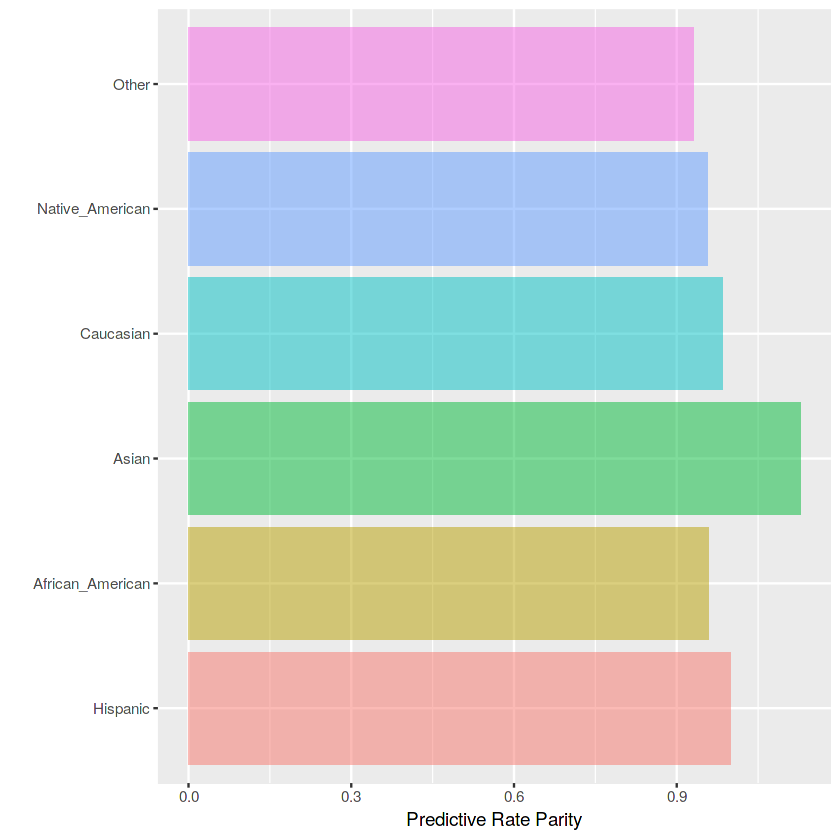

In [11]:
#collapse-show
res1h$Metric_plot

Some fairness metrics do not require probabilistic predictions and can work with class predictions. When predicted probabilities are supplied, an extra density plot will be output displaying the distributions of probabilities of all subgroups and the user-defined cutoff:

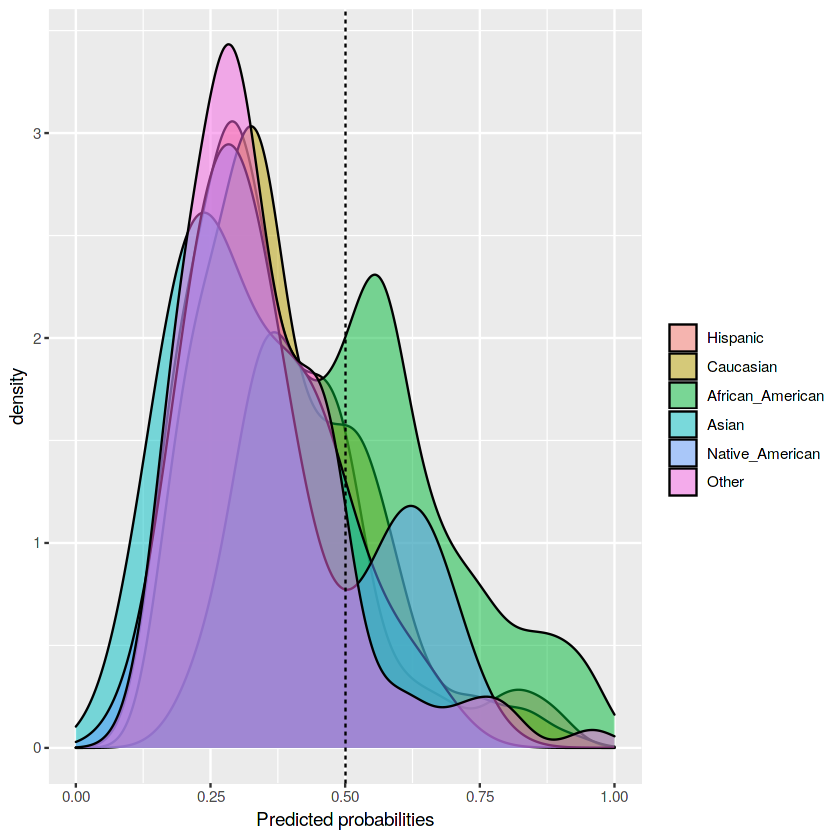

In [12]:
#collapse-show
res1h$Probability_plot

Let's now compare the results to the second model that does not use ethnicity as a feature:

In [14]:
#collapse-show

# model 2
res2 <- pred_rate_parity(data         = df_valid, 
                         outcome      = 'Two_yr_Recidivism', 
                         group        = 'ethnicity',
                         probs        = 'prob_2', 
                         preds_levels = c('no','yes'), 
                         cutoff       = 0.5, 
                         base         = 'Caucasian')
res2$Metric

,Caucasian,African_American,Asian,Hispanic,Native_American,Other
Precision,0.690678,0.6609808,0.8181818,0.706422,0.6666667,0.6625000
Predictive Rate Parity,1.000000,0.9570029,1.1846068,1.022795,0.9652352,0.9592025


We can see two things. 

First, excluding `ethnicity` from the features slightly increases precision for African-American defendants but results in a lower precision for a number of other groups. This illustrates that improving a model for one group may cost a fall in the predictive performance for the general population. Depending on the context, it is a task of a decision-maker to decide what is best.

Second, excluding `ethnicity` does not align the predictive rate parities substantially closer to one. This illustrates another important research finding: removing a sensitive variable does not guarantee that a model stops discriminating. Ethnicity correlates with other features and is still implicitly included in the input data. In order to make the classifier more fair, one would neet to consider more sophisticated techniques than simply dropping the sensitive attribute.

In the rest of this tutorial, we will go through the functions that cover the remaining implemented fairness metrics, illustrating the corresponding equations and outputs. You can find more details on each of the fairness metric functions in the package documentation. Please don't hesitate to use the built-in helper to see further details and examples on the implemented metrics:

In [16]:
#collapse-show
?fairness::pred_rate_parity

## Demographic parity

Demographic parity is one of the most popular fairness indicators in the literature. Demographic parity is achieved if the absolute number of positive predictions in the subgroups are close to each other. This measure does not take true class into consideration and only depends on the model predictions.

Formula: **(TP + FP)**

In [18]:
#collapse-show
res_dem <- dem_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism',
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'Caucasian')
res_dem$Metric

,Caucasian,African_American,Asian,Hispanic,Native_American,Other
Positively classified,147,504.000000,2.00000000,22.0000000,1.000000000,10.00000000
Demographic Parity,1,3.428571,0.01360544,0.1496599,0.006802721,0.06802721


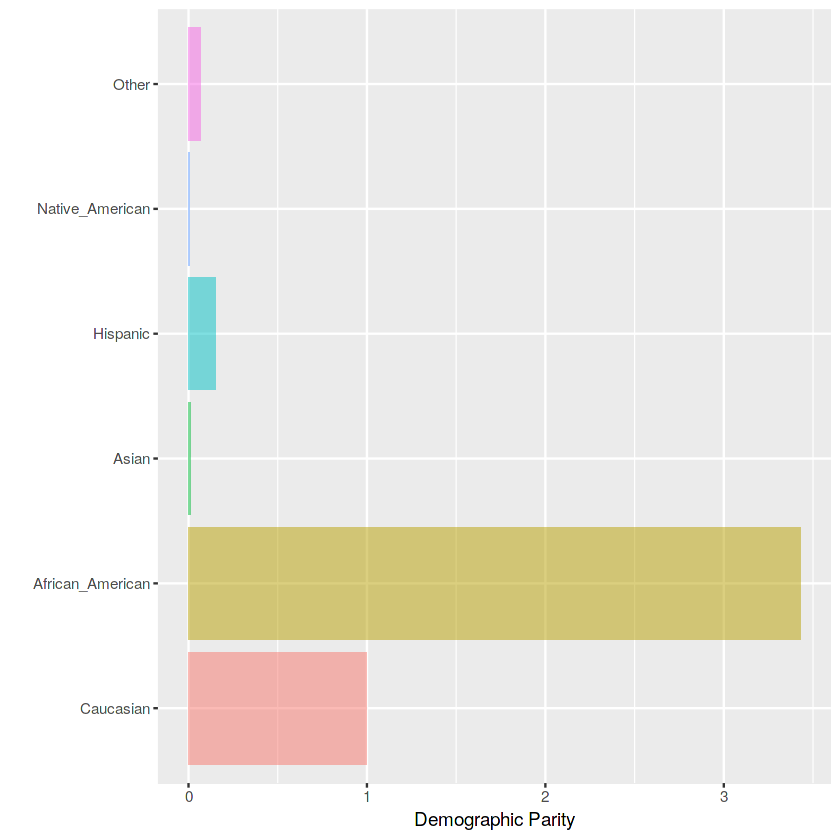

In [19]:
#collapse-show
res_dem$Metric_plot

Of course, comparing the absolute number of positive predictions will show a high disparity when the number of cases within each group is different, which artificially boosts the disparity. This is true in our case:

In [20]:
#collapse-show
table(df_valid$ethnicity)


       Caucasian African_American            Asian         Hispanic 
             622              962               16              144 
 Native_American            Other 
               4              104 

To address this, we can use proportional parity.

## Proportional parity

Proportional parity is very similar to demographic parity but modifies it to address the issue discussed above. Proportional parity is achieved if the proportion of positive predictions in the subgroups are close to each other. Similar to the demographic parity, this measure also does not depend on the true labels.

Formula: **(TP + FP) / (TP + FP + TN + FN)**

In [21]:
#collapse-show
res_prop <- prop_parity(data         = df_valid, 
                        outcome      = 'Two_yr_Recidivism',
                        group        = 'ethnicity',
                        probs        = 'prob_1', 
                        preds_levels = c('no','yes'), 
                        cutoff       = 0.5, 
                        base         = 'Caucasian')
res_prop$Metric

,Caucasian,African_American,Asian,Hispanic,Native_American,Other
Proportion,0.2363344,0.5239085,0.1250000,0.1527778,0.250000,0.09615385
Proportional Parity,1.0000000,2.2168102,0.5289116,0.6464475,1.057823,0.40685505


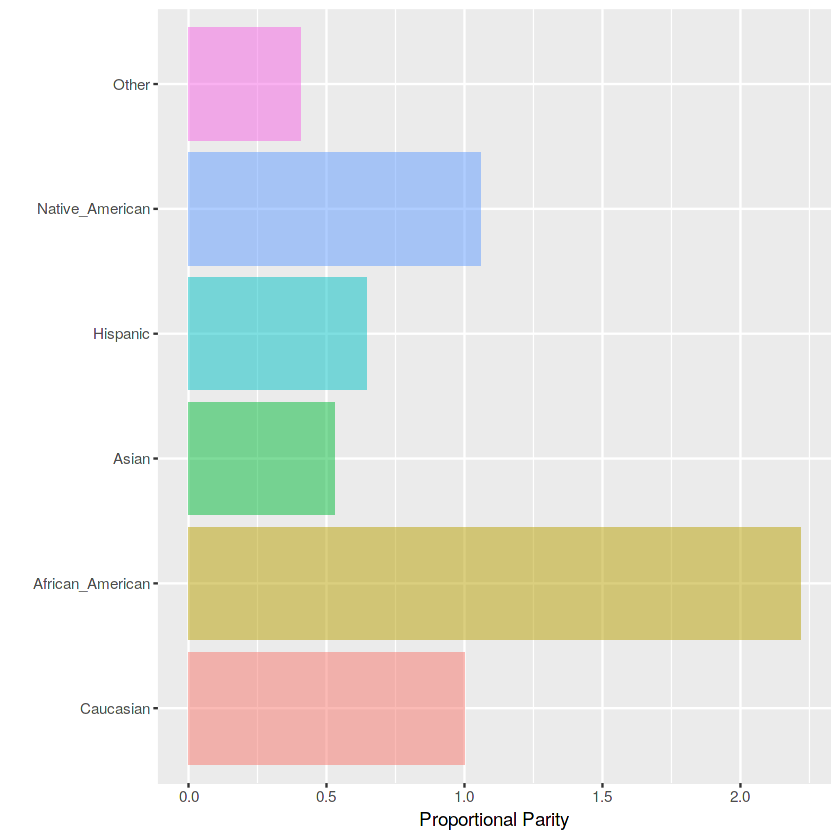

In [22]:
#collapse-show
res_prop$Metric_plot

The proportional parity still shows that African-American defendants are treated unfairly by our model. At the same time, the disparity is lower compared to the one observed with the demographic parity.

All the remaining fairness metrics account for both model predictions and the true labels.

## Equalized odds

Equalized odds are achieved if the sensitivities in the subgroups are close to each other. The group-specific sensitivities indicate the number of the true positives divided by the total number of positives in that group. 

Formula: **TP / (TP + FN)**

In [23]:
#collapse-show
res_eq <- equal_odds(data         = df_valid, 
                     outcome      = 'Two_yr_Recidivism', 
                     group        = 'ethnicity',
                     probs        = 'prob_1', 
                     preds_levels = c('no','yes'), 
                     cutoff       = 0.5, 
                     base         = 'African_American')  
res_eq$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
Sensitivity,0.6710526,0.8423773,0.9166667,0.9042553,1.000000,0.983871
Equalized odds,1.0000000,1.2553073,1.3660131,1.3475177,1.490196,1.466161


## Accuracy parity

Accuracy parity is achieved if the accuracies (all accurately classified examples divided by the total number of examples) in the subgroups are close to each other.

Formula: **(TP + TN) / (TP + FP + TN + FN)**

In [24]:
#collapse-show
res_acc <- acc_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'African_American')
res_acc$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
Accuracy,0.6860707,0.6623794,0.750000,0.6805556,0.750000,0.6730769
Accuracy Parity,1.0000000,0.9654682,1.093182,0.9919613,1.093182,0.9810606


## False negative rate parity

False negative rate parity is achieved if the false negative rates (the ratio between the number of false negatives and the total number of positives) in the subgroups are close to each other.

Formula: **FN / (TP + FN)**

In [25]:
#collapse-show
res_fnr <- fnr_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'African_American')
res_fnr$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
FNR,0.3289474,0.1576227,0.08333333,0.09574468,0,0.01612903
FNR Parity,1.0000000,0.4791731,0.25333333,0.29106383,0,0.04903226


## False positive rate parity

False positive rate parity is achieved if the false positive rates (the ratio between the number of false positives and the total number of negatives) in the subgroups are close to each other.

Formula: **FP / (TN + FP)**

In [26]:
#collapse-show
res_fpr <- fpr_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'African_American')
res_fpr$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
FPR,0.3003953,0.6340426,0.750000,0.740000,0.500000,0.7857143
FPR Parity,1.0000000,2.1106943,2.496711,2.463421,1.664474,2.6156015


## Negative predictive value parity

Negative predictive value parity is achieved if the negative predictive values in the subgroups are close to each other. The negative predictive value is computed as a ratio between the number of true negatives and the total number of predicted negatives. This function can be considered the ‘inverse’ of the predictive rate parity.

Formula: **TN / (TN + FN)**

In [27]:
#collapse-show
res_npv <- npv_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'African_American')
res_npv$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
NPV,0.702381,0.5850340,0.5000000,0.5909091,1.000000,0.900000
NPV Parity,1.000000,0.8329298,0.7118644,0.8412943,1.423729,1.281356


## Specificity parity

Specificity parity is achieved if the specificities (the ratio of the number of the true negatives and the total number of negatives) in the subgroups are close to each other. This function can be considered the ‘inverse’ of the equalized odds.

Formula: **TN / (TN + FP)**

In [28]:
#collapse-show
res_sp <- spec_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'ethnicity',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'African_American')
res_sp$Metric

,African_American,Caucasian,Asian,Hispanic,Native_American,Other
Specificity,0.6996047,0.3659574,0.2500000,0.2600000,0.5000000,0.2142857
Specificity Parity,1.0000000,0.5230917,0.3573446,0.3716384,0.7146893,0.3062954


Apart from the parity-based metrics presented above, two additional comparisons are implemented: ROC AUC comparison and Matthews correlation coefficient comparison.

## ROC AUC comparison

This function calculates ROC AUC and visualizes ROC curves for all subgroups. Note that probabilities must be defined for this function. Also, as ROC evaluates all possible cutoffs, the cutoff argument is excluded from this function.

In [29]:
#collapse-show
res_auc <- roc_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'Female',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      base         = 'Male')
res_auc$Metric

Setting direction: controls < cases

Setting direction: controls < cases



,Male,Female
ROC AUC,0.7221429,0.7192349
ROC AUC Parity,1.0000000,0.9959731


Apart from the standard outputs, the function also returns ROC curves for each of the subgroups:

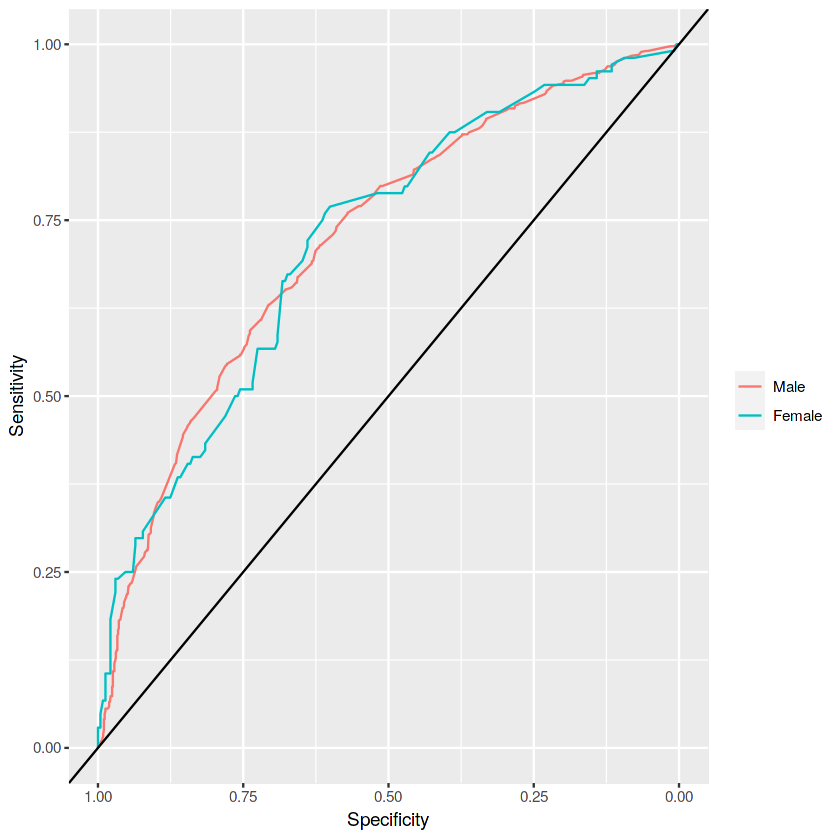

In [30]:
#collapse-show
res_auc$ROCAUC_plot

## Matthews correlation coefficient comparison

The Matthews correlation coefficient (MCC) takes all four classes of the confusion matrix into consideration. [MCC](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) is sometimes referred to as the single most powerful metric in binary classification problems, especially for data with class imbalances.

Formula: **(TP×TN-FP×FN)/√((TP+FP)×(TP+FN)×(TN+FP)×(TN+FN))**

In [32]:
#collapse-show
res_mcc <- mcc_parity(data         = df_valid, 
                      outcome      = 'Two_yr_Recidivism', 
                      group        = 'Female',
                      probs        = 'prob_1', 
                      preds_levels = c('no','yes'), 
                      cutoff       = 0.5, 
                      base         = 'Male')
res_mcc$Metric

,Male,Female
MCC,0.3316558,0.2893650
MCC Parity,1.0000000,0.8724859


# 6. Closing words

You have read through the fairness R package tutorial! By now, you should have a solid grip on algorithmic group fairness metrics. 

We hope that you will be able to use the R package in your data analysis! Please let me know if you run into any issues while working with the package in the comment window below or on [GitHub](https://github.com/kozodoi/fairness). Please also feel free to contact the authors if you have any feedback.

**Acknowlegments:**
- Calders, T., & Verwer, S. (2010). Three naive Bayes approaches for discrimination-free classification. Data Mining and Knowledge Discovery, 21(2), 277-292.
- Chouldechova, A. (2017). Fair prediction with disparate impact: A study of bias in recidivism prediction instruments. Big data, 5(2), 153-163.
- Feldman, M., Friedler, S. A., Moeller, J., Scheidegger, C., & Venkatasubramanian, S. (2015, August). Certifying and removing disparate impact. In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 259-268). ACM.
- Friedler, S. A., Scheidegger, C., Venkatasubramanian, S., Choudhary, S., Hamilton, E. P., & Roth, D. (2018). A comparative study of fairness-enhancing interventions in machine learning. arXiv preprint arXiv:1802.04422.
- Zafar, M. B., Valera, I., Gomez Rodriguez, M., & Gummadi, K. P. (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th International Conference on World Wide Web (pp. 1171-1180). International World Wide Web Conferences Steering Committee.